<script src="https://platform.linkedin.com/badges/js/profile.js" async defer type="text/javascript"></script>

# Time Series LSTM and MLR Model Development Exercise with Scalecast
## James M. Freire
## james.freire@gmail.com
## http://www.onigiri.com
* In this exercise I am examining the use of machine learning to create a forecast of Google Trends data. I examine the use of two types of machine learning, LSTM and MLR and compare their performance. I go through several iterations of LSTM and fine-tune its paramters to give the best results while leveraging Scalecast for rapid iteration.

### Interesting points about the Google Trends data
* There is daily granularity up until 3 months, then it becomes weekly. I have worked with the data on a weekly basis. 
* Google normalizes the data. The largest percent query volume in the time series is '100', all other values are set to smaller values. This introduces a bias 
* The gtrends library does account for the bias in normalization with a workaround, however I selected the PyTrends as the library had good documentation and I started working with it. 

In [1]:
#There are two packages below that might not be part of the reviewer's normal library set, PyTrends and scalecast. The pip install has been commented out just in case. 
#!pip install pytrends
#!pip install scalecast
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
sns.set(rc={'figure.figsize':(12,8)})

#### After examining a few packages, I settled on PyTrends for connecting to the Google API. Normally I would like to extract a specific date range, but this exercise i'm keeping it relative to 'today' as I got 400 errors for the interval I wanted the results to be in (weekly)

In [3]:
# connect to google 
from pytrends.request import TrendReq
pytrends = TrendReq(hl='en-US', tz=360) 

In [4]:
#Grab data for the past 5 years (default)
kw_list = ["Business Loan"] # list of keywords to get data 
pytrends.build_payload(kw_list, cat=0,geo='US') 
#Interest over Time
df = pytrends.interest_over_time() 
df = df.reset_index()
df.drop('isPartial', axis=1, inplace=True)

# Model Development using Scalecast

### Why am I using Scalecast?
* It is a modeling procedure, wrapper and results container. It is a fast way to try out lots of models and make comparisons. 
* Scalecast, while seemingly nascent is an amazing tool that helps save time in creating performance plots, performance tables and forecast data.
* For using an LSTM model, it allows me to rapidly create tensorflow models in less lines of code. I don't have to create multiple lines of layers.
* Downside? It is not as tunable as coding direct, but for exploratory analysis of models, it's fabulous.

In [5]:
from scalecast.Forecaster import Forecaster

## Exporatory Data Analysis

### Get the top 3 related queries to 'Business Loan', plot their overall trends, and see how they align. 

In [6]:
kw_list = ["Business Loan"] # list of keywords to get data 
pytrends.build_payload(kw_list, cat=0,geo='US') 
#Interest over Time
related_queries = pytrends.related_queries() 
top_related = related_queries.get('Business Loan').get('top')
top_related.iloc[[0,1,2]]

,query,value
0,loan for business,100
1,small business,96
2,small business loan,92


In [7]:
kw_list = ['Business Loan','small business','loan for business','small business loan']
pytrends.build_payload(kw_list, cat=0,geo='US') 
related_queries_interest = pytrends.interest_over_time() 
related_queries_interest.drop('isPartial', axis=1, inplace=True)

### Continue focusing on the 'Business Loan' term
- The term 'Small Business' has relatively higher interest, however it is a more general topic. While we can see it trends similarly to our other terms, 'Business Loan' has interest that aligns the other loan search terms.

<AxesSubplot:xlabel='date'>

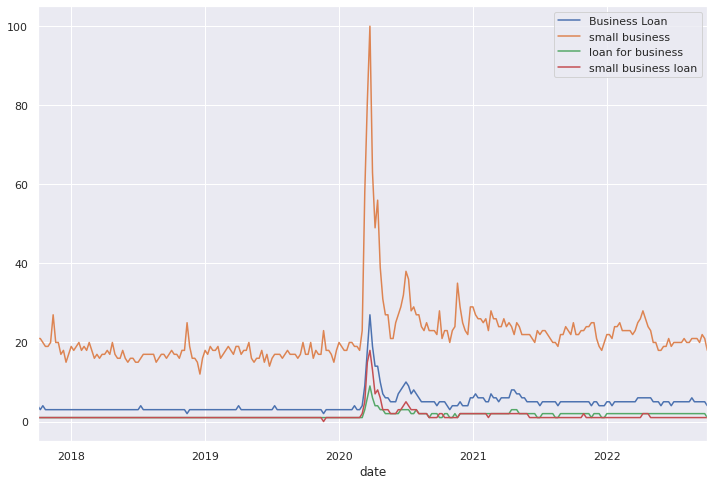

In [8]:
related_queries_interest.plot()

#### Since we are using the past year as training data, let's take a look at the distribution of the these terms. This another visual I use to give a better idea if there are extremes, the modality, and how spread out it may be. 

<AxesSubplot:>

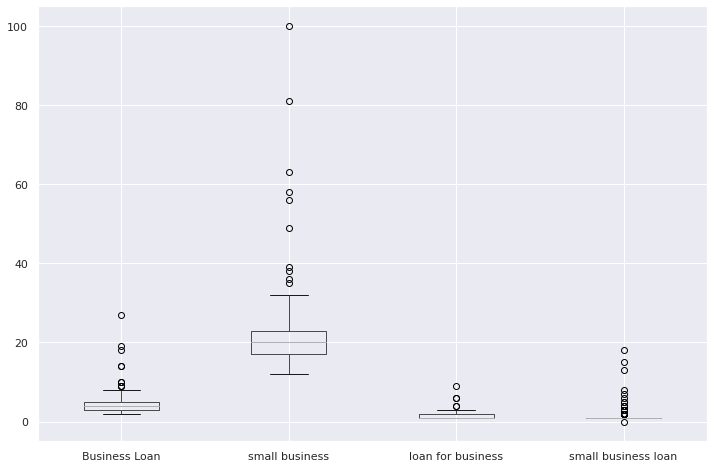

In [9]:
related_queries_interest.boxplot()

#### Examining the trends data we see an 'isPartial' field, what does it do? It indicates if there is a time period that is not complete. We don't have any rows that are incomplete, so we can remove this column.

In [ ]:
df.drop('isPartial', axis=1, inplace=True)

In [11]:
#df = df.set_index('date')

In [12]:
#df.drop('index',axis=1,inplace=True)

#### Check if there is any unwanted characters in the "Business Loan" column, there are none.

In [13]:
print (df[pd.to_numeric(df['Business Loan'], errors='coerce').isnull()]["Business Loan"].unique())

[]


### Between 2020 and 2021 because of events surrounding COVID19 we see a lot of volatility in the time series. However, we won't be modeling that far back and the data looks relatively more stable the past 1.5 years.

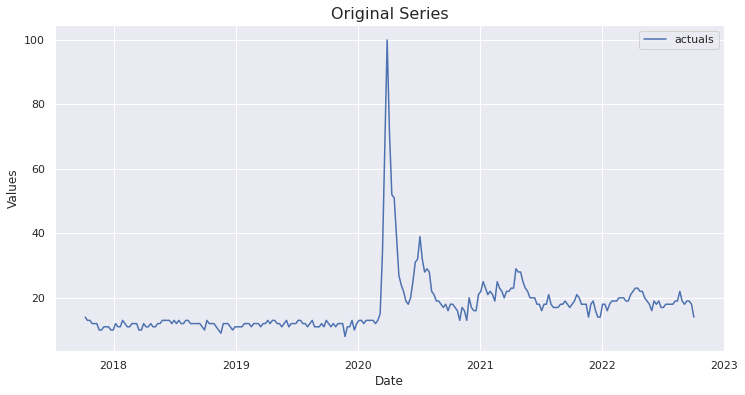

In [14]:
f = Forecaster(y=df['Business Loan'],current_dates=df['date'])
f.plot()
plt.title('Original Series',size=16)
plt.show()

### Examine the time series by viewing Autocorrelation and Partial Autocorrelation. It will tell us how much our Y value is correlated to itself, and how far back.

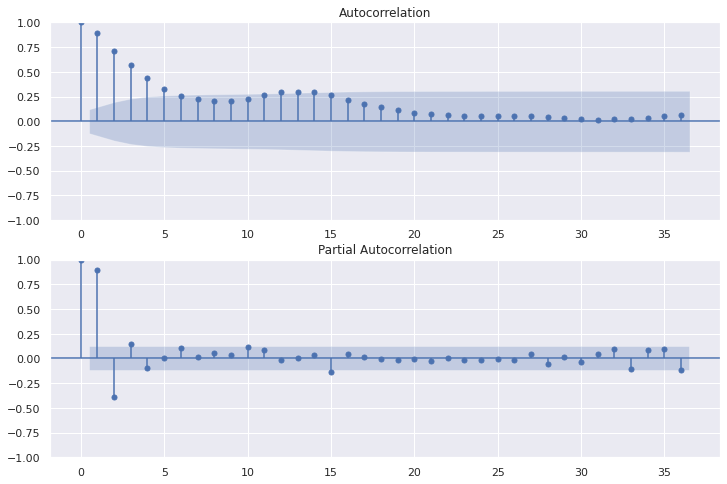

In [15]:
figs, axs = plt.subplots(2, 1)
f.plot_acf(ax=axs[0],lags=36)
f.plot_pacf(ax=axs[1],lags=36)
plt.show()

### How does our time series trend and are there any seasonalities. 

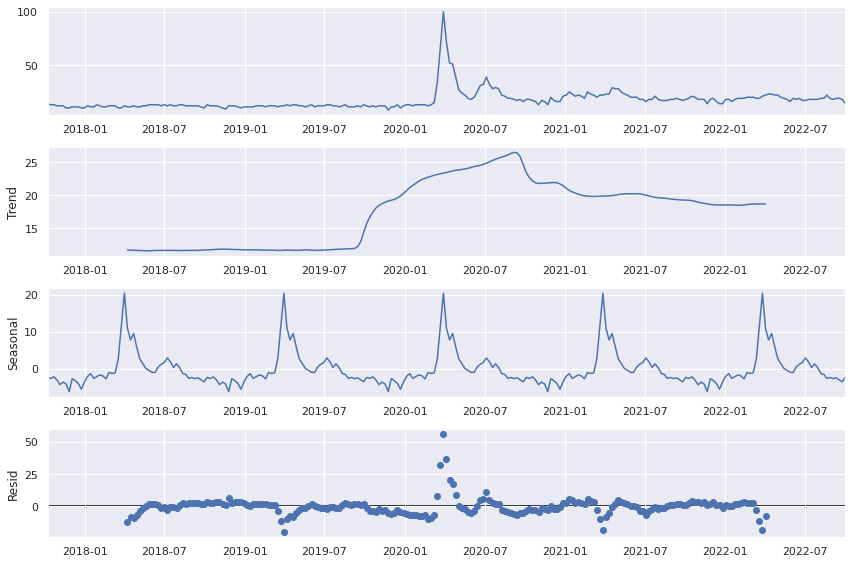

In [16]:
f.seasonal_decompose().plot()
plt.show()

### Our data is 'stationary', that means the structure of the data is not dependent on the time and the time period we're examining does not have an increasing trend. Stationary data is easier to model and forecast. What does it look like? When plotting the rolling mean and standard deviation they will remain flat if it is stationary. 

### The Dickey-Fuller test allows us to statistically test for stationarity using the unit root. All the unit root is, is the measurement of how much stationarity a time series has. 

In [17]:
critical_pval = 0.05
print('-'*100)
print('Augmented Dickey-Fuller results:')
stat, pval, _, _, _, _ = f.adf_test(full_res=True)
print('the test-stat value is: {:.2f}'.format(stat))
print('the p-value is {:.4f}'.format(pval))
print('the series is {}'.format('stationary' if pval < critical_pval else 'not stationary'))
print('-'*100)

----------------------------------------------------------------------------------------------------
Augmented Dickey-Fuller results:
the test-stat value is: -4.59
the p-value is 0.0001
the series is stationary
----------------------------------------------------------------------------------------------------


### Set the test and forecast timeframe (53 weeks), along with the estimator we are going to use (lstm).

In [18]:
f.set_test_length(53)       # 53 weeks (observations) to test the results
f.generate_future_dates(53) # 53 future points (weeks) to forecast
f.set_estimator('lstm')     # Set the Estimator to LSTM neural network

#### First run an LSTM model with default settings and with the only option being the confidence interval overalay. 

7/7 [==============================] - 0s 1ms/step


<AxesSubplot:xlabel='Date', ylabel='Values'>

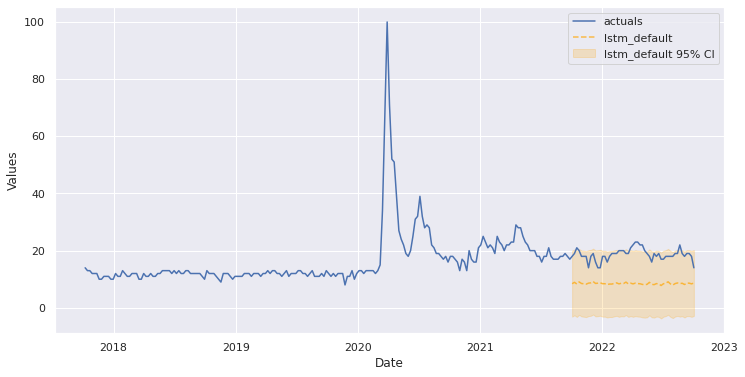

In [19]:
f.manual_forecast(call_me='lstm_default')
f.plot_test_set(ci=True)

### 'lstm_24lags' - 2nd Model
#### Here we add the 'lags' option.

#### Why do we used lagged features?

6/6 [==============================] - 0s 5ms/step


<AxesSubplot:xlabel='Date', ylabel='Values'>

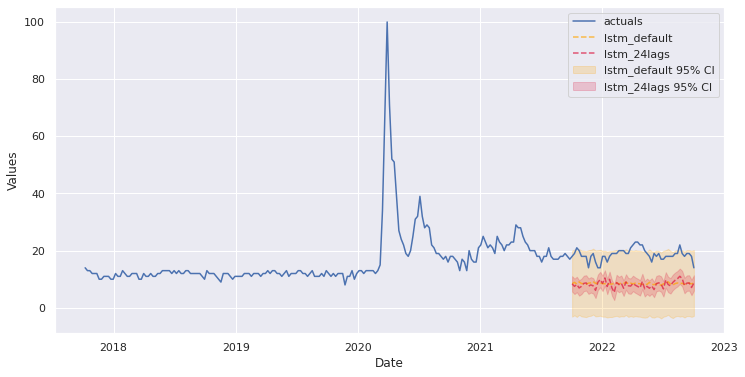

In [20]:
f.manual_forecast(call_me='lstm_24lags',lags=24)
f.plot_test_set(ci=True)

### 'lstm_24lags_5epochs' - 3rd Model 
#### Add more epochs to give it more time to train, and validate the model as it is training.
 

Epoch 1/5
4/4 [==============================] - 2s 225ms/step - loss: 0.1291 - val_loss: 0.0381
Epoch 2/5
4/4 [==============================] - 0s 27ms/step - loss: 0.1235 - val_loss: 0.0331
Epoch 3/5
4/4 [==============================] - 0s 26ms/step - loss: 0.1182 - val_loss: 0.0285
Epoch 4/5
4/4 [==============================] - 0s 24ms/step - loss: 0.1131 - val_loss: 0.0241
Epoch 5/5
1/1 [==============================] - 0s 307ms/step
Epoch 1/5
5/5 [==============================] - 2s 103ms/step - loss: 0.1264 - val_loss: 0.0341
Epoch 2/5
5/5 [==============================] - 0s 23ms/step - loss: 0.1190 - val_loss: 0.0275
Epoch 3/5
5/5 [==============================] - 0s 21ms/step - loss: 0.1108 - val_loss: 0.0239
Epoch 4/5
5/5 [==============================] - 0s 20ms/step - loss: 0.1028 - val_loss: 0.0245
Epoch 5/5
6/6 [==============================] - 0s 5ms/step


<AxesSubplot:xlabel='Date', ylabel='Values'>

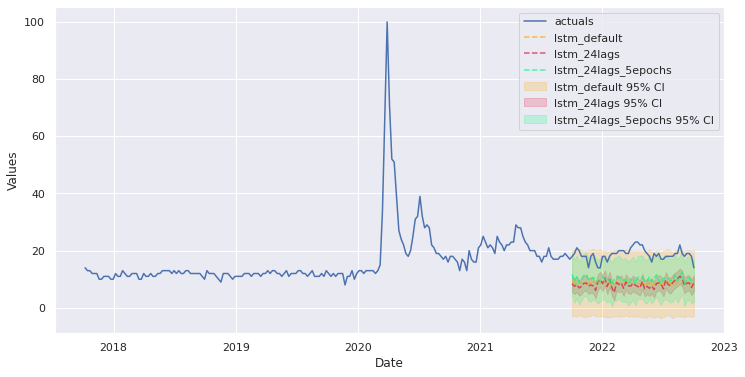

In [21]:
f.manual_forecast(call_me='lstm_24lags_5epochs',
                  lags=24,
                  epochs=5,
                  validation_split=.2,
                  shuffle=True)
f.plot_test_set(ci=True)

### 'lstm_24lags_earlystop_3layers' - 4th Model
#### Increase the number of layers to 3, and epochs to 25. 
#### Implemented early stopping to monitor validation loss, and have it early stop after 5 layers if no improvement

Epoch 1/25
4/4 [==============================] - 5s 412ms/step - loss: 0.1228 - val_loss: 0.0337
Epoch 2/25
4/4 [==============================] - 0s 54ms/step - loss: 0.1148 - val_loss: 0.0296
Epoch 3/25
4/4 [==============================] - 0s 45ms/step - loss: 0.1078 - val_loss: 0.0300
Epoch 4/25
4/4 [==============================] - 0s 46ms/step - loss: 0.1024 - val_loss: 0.0254
Epoch 5/25
4/4 [==============================] - 0s 45ms/step - loss: 0.0970 - val_loss: 0.0204
Epoch 6/25
4/4 [==============================] - 0s 44ms/step - loss: 0.0924 - val_loss: 0.0176
Epoch 7/25
4/4 [==============================] - 0s 44ms/step - loss: 0.0885 - val_loss: 0.0182
Epoch 8/25
4/4 [==============================] - 0s 43ms/step - loss: 0.0851 - val_loss: 0.0212
Epoch 9/25
4/4 [==============================] - 0s 45ms/step - loss: 0.0825 - val_loss: 0.0187
Epoch 10/25
4/4 [==============================] - 0s 47ms/step - loss: 0.0800 - val_loss: 0.0176
Epoch 11/25
4/4 [===========

<AxesSubplot:xlabel='Date', ylabel='Values'>

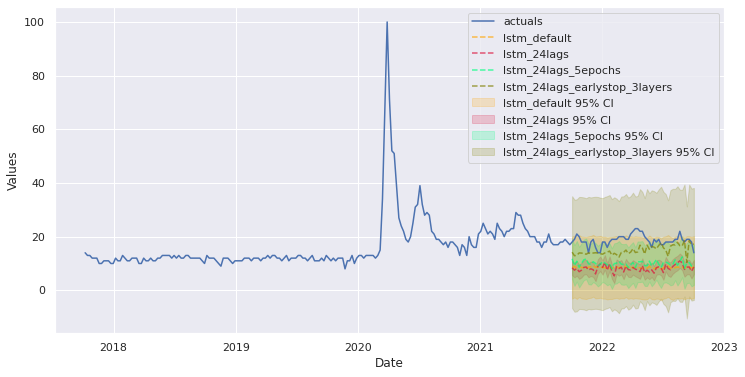

In [22]:
from tensorflow.keras.callbacks import EarlyStopping
f.manual_forecast(call_me='lstm_24lags_earlystop_3layers',
                  lags=24,
                  epochs=25,
                  validation_split=.2,
                  shuffle=True,
                  callbacks=EarlyStopping(monitor='val_loss',
                                          patience=5),
                  lstm_layer_sizes=(16,16,16),
                  dropout=(0,0,0))
f.plot_test_set(ci=True)

### 'lstm_best' - 5th Model
#### Add more layers, the Adam optimizer and used a tanh activation function

Epoch 1/15
3/3 [==============================] - 6s 896ms/step - loss: 0.1292 - val_loss: 0.0268
Epoch 2/15
3/3 [==============================] - 0s 115ms/step - loss: 0.1101 - val_loss: 0.0426
Epoch 3/15
3/3 [==============================] - 0s 110ms/step - loss: 0.0960 - val_loss: 0.0330
Epoch 4/15
3/3 [==============================] - 0s 108ms/step - loss: 0.0877 - val_loss: 0.0335
Epoch 5/15
3/3 [==============================] - 0s 116ms/step - loss: 0.0826 - val_loss: 0.0389
Epoch 6/15
3/3 [==============================] - 0s 105ms/step - loss: 0.0796 - val_loss: 0.0304
Epoch 7/15
3/3 [==============================] - 0s 104ms/step - loss: 0.0778 - val_loss: 0.0334
Epoch 8/15
3/3 [==============================] - 0s 107ms/step - loss: 0.0759 - val_loss: 0.0373
Epoch 9/15
3/3 [==============================] - 0s 103ms/step - loss: 0.0756 - val_loss: 0.0352
Epoch 10/15
3/3 [==============================] - 0s 109ms/step - loss: 0.0752 - val_loss: 0.0333
Epoch 11/15
3/3 [==

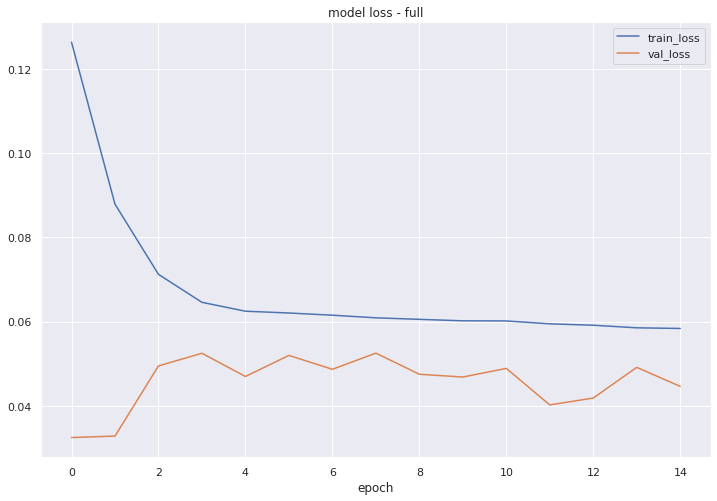

6/6 [==============================] - 0s 54ms/step


In [23]:
f.manual_forecast(call_me='lstm_best',
                  lags=36,
                  batch_size=32,
                  epochs=15,
                  validation_split=.2,
                  shuffle=True,
                  activation='tanh',
                  optimizer='Adam',
                  learning_rate=0.001,
                  lstm_layer_sizes=(72,)*4,
                  dropout=(0,)*4,
                  plot_loss=True)

### Performance of all the LSTM models 

<AxesSubplot:xlabel='Date', ylabel='Values'>

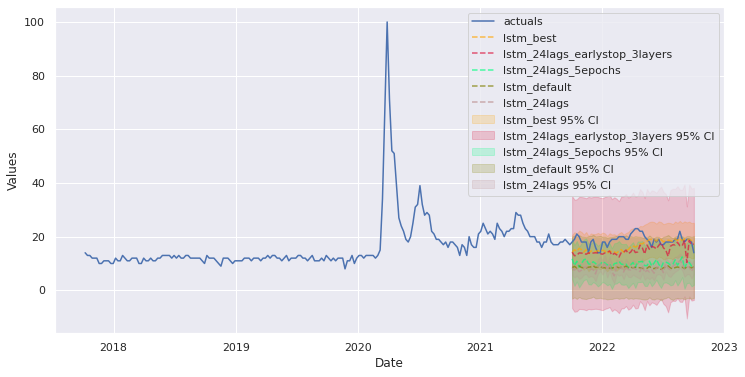

In [24]:
f.plot_test_set(order_by='LevelTestSetMAPE',models='top_5',ci=True)

### 6th Model - We'll make a comparison against a simple MLR model. Although not the case here, sometimes simple is better and can save a lot of computational time and development resources.
### Multi Linear Regression

In [25]:
f.set_estimator('mlr')
f.add_ar_terms(24) 
f.add_seasonal_regressors('month','quarter',dummy=True) # 2.
f.add_seasonal_regressors('year') 
f.add_time_trend()
f.diff() 

<AxesSubplot:xlabel='Date', ylabel='Values'>

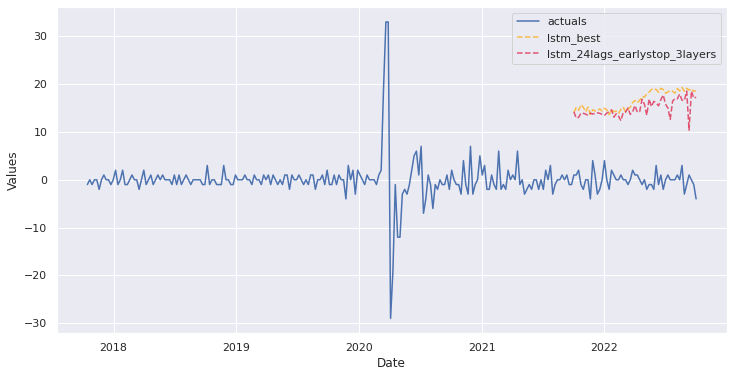

In [26]:
f.manual_forecast()
f.plot_test_set(order_by='LevelTestSetMAPE',models='top_2')

### Export the model summaries and forecasts

In [27]:
f.export('model_summaries',determine_best_by='LevelTestSetMAPE')[
    ['ModelNickname',
     'LevelTestSetMAPE',
     'LevelTestSetRMSE',
     'best_model']
]

,ModelNickname,LevelTestSetMAPE,LevelTestSetRMSE,best_model
0,lstm_best,0.142226,3.412726,True
1,lstm_24lags_earlystop_3layers,0.201687,4.606636,False
2,mlr,0.426078,9.013081,False
3,lstm_24lags_5epochs,0.457425,8.895648,False
4,lstm_default,0.537945,10.342884,False
5,lstm_24lags,0.555079,10.716867,False


In [28]:
forecasts = f.export(dfs='all_fcsts',determine_best_by='LevelTestSetMAPE',models='top_3')

In [29]:
forecasts = forecasts[['DATE','lstm_best','lstm_24lags_earlystop_3layers','lstm_24lags_5epochs']]

### Forecast of 3, 6, 9, 12 months of the models

In [30]:
forecast_table = forecasts.loc[[13, 26, 39, 52]]
forecast_table.insert(1,'Month', [3,6,9,12])
forecast_table

,DATE,Month,lstm_best,lstm_24lags_earlystop_3layers,lstm_24lags_5epochs
13,2023-01-08,3,16.047752,15.801971,11.862243
26,2023-04-09,6,16.157583,11.302995,5.112244
39,2023-07-09,9,17.369109,18.677673,12.139292
52,2023-10-08,12,18.436057,17.079034,2.415707


### Forecast results chart for 3, 6, 9, 12 months

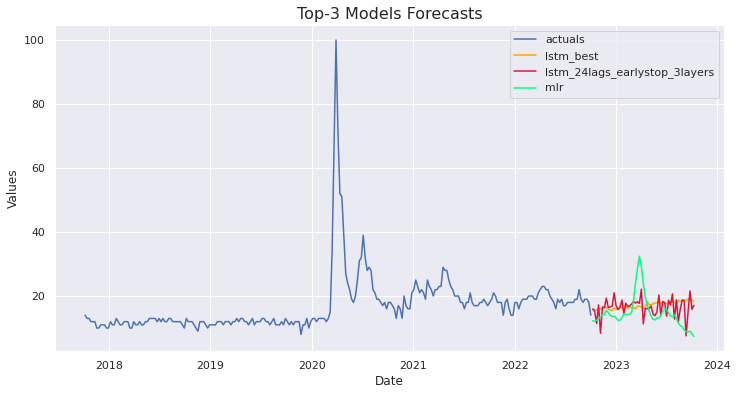

In [31]:
f.plot(order_by='LevelTestSetMAPE',models='top_3')
plt.title('Top-3 Models Forecasts',size=16)
plt.show()

## Business Use Cases:
* Demand Forecast: LSTM can analyze upcoming trends in the market and forecast upcoming demand for loans. More features could be added that relate to emerging businesses in particular locales that can be targeted. 

* Targeted Advertising: Taking advantage of the regional attributes available in the API, resources such as targeted advertising can be leveraged in specific locales.

* Risk Management: The increase or decrease in loan interest along with other interest searches (such as 'increased interest rates', 'recession', etc.) and leading economic indicators could be leveraged to help guide credit tightening policies or changes in loan terms. 
 

## What are the strengths/weaknesses of the two modeling methodologies? (LSTM, MLR)

* LSTM Strengths: It essentially the defacto machine learning method for timeseries forecasting. Highly tunable, customizable with a lot of documentation. 
* LSTM: Computationally more intense, requires more tuning, adjustment and experimentation. Scalecast does allow for fast experimentation and iteration

* MLR Strengths: It's simple, easy to develop and implement. It is linear regression that tracks the movement of a dependent variable in relation to multiple independent variables. 
* MLR Weaknesses: It's simple, it does not 'remember' values over any interval and does not take into account any lags of duration. There is no decision tree like with tensorflow where we can leverage activation layers based on probability functions. It is a straight regression calculation against the variables for moments in time. 

* Other methods tested:
    I tested the model against a log transformed dataset. While it did give a lower RMSE in the interest of time, I did not have time to continue engineering the dataflow to return the results back to a non-log dataset

## What do the results mean and how do I interpret them?
- MAPE, Mean Absolute Percentage Error measures the prediction accuracy of the model. It is the average of all the percentage errors between the values our model predicted and the actual values that existed in our historical data. 
- Our best MAPE score was 14.2%, with more time we should aim for below 10%
- Another indicator at looking at model performance I used is RMSE, or 'Root Mean Square Error'. 
    - RMSE tells us how far off from the observed (or 'real') value we are with a predicted value the model comes up with. When the computer comes up with '15' for a prediction on a particular past date, and the actual value was 13, we track that difference as what is called a residual.
    - Residuals are then calculated all together to give us a variance, or how spread out the values. 
    - RMSE is a way to compare models against each other and how 'tight' they essentially are against the historical data. 
    - Overfitting and other considerations aside, a lower relative RMSE compared to other models the better the relative fit is.


## Other features analyzed: 

- I tested the model against a log transformed dataset. While it did give a lower RMSE, in the interest of time I did not continue to engineer the dataflow to return the results back to a non-log dataset.
- I had tried a number of moving averages as a feature, however while they marginally improved the RMSE of the models, I did not find that they were significant enough to dramatically increase the size of the notebook which might make the work more confusing.

## Technical Takeaways:

- The LSTM model titled 'lstm_best', utilizing lags, tanh activation and the Adam optimizer gave us the best results. 
- I used the tanh activation to keep the values scaled between -1 and 1 as it also helps mitigate exploding gradient during back-propagation. ReLu would likely have the same effect but I went with tanh in this experiment
- Future considerations: I would like to continue exploring the use of the 'interest_by_region' method and add in an addional feature to the dataset of interest by state. 

In [32]:
data  = pytrends.related_queries()

data['Business Loan']['top'] 

,query,value
0,loan for business,100
1,small business,96
2,small business loan,92
3,get business loan,52
4,get a business loan,41
5,business loans,38
6,business credit,36
7,business loan for small business,33
8,loan for small business,32
9,sba,29
